# Project Checkpoint 1 - EDA

**Group:** Annie Lin, Micah Yong, Daniel Yamada, Bongi Fleischer

In [68]:
# Import statements
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# Package settings
pd.options.mode.chained_assignment = None

## Research Question 1: How well do transportation levels (e.g., combination of public transit ridership and private vehicle ridership) and spending in the transportation sector predict employment rate?

Resources
- https://www.jpmorgan.com/commercial-banking/insights/the-economic-case-for-infrastructure-spending

### Part 1: EDA

In this part, we will clean the monthly transportation statistics dataset and make initial observations about the data. 

First, let's narrow down the columns we're interested in using as predictors. 

In [69]:
# Load in original dataframe 
data = pd.read_csv("Monthly_Transportation_Statistics.csv")

# We want to keep track of time 
metadata_columns = ["Date", "Index"]

# We want to compute employment rate 
output_columns = ["Real Gross Domestic Product - Seasonally Adjusted"]

extra_output_columns = ["Labor Force Participation Rate - Seasonally Adjusted", 
                        "Unemployment Rate - Seasonally Adjusted",
                        "Unemployed - Seasonally Adjusted"]

# We will utilize measures of transportation ridership + transportation spending 
ridership_columns = [
    "Transit Ridership - Other Transit Modes - Adjusted",
    "Transit Ridership - Fixed Route Bus - Adjusted",
    "Transit Ridership - Urban Rail - Adjusted",
    "Passenger Rail Passengers",
    "Passenger Rail Total Train Miles",
    "Passenger Rail Employee Hours Worked",
    "Transportation Services Index - Passenger",
    "U.S.-Canada Incoming Person Crossings",
    "U.S.-Mexico Incoming Person Crossings",
    "Auto sales"
]

spending_columns = [
    "State and Local Government Construction Spending - Transportation",
    "State and Local Government Construction Spending - Mass Transit",
    "State and Local Government Construction Spending - Total",
    "State and Local Government Construction Spending - Pavement", 
    "State and Local Government Construction Spending - Highway and Street",
    "State and Local Government Construction Spending - Automotive",
    "State and Local Government Construction Spending - Infrastructure",
]

prediction_columns = ridership_columns + spending_columns
all_columns = metadata_columns + output_columns + extra_output_columns + prediction_columns 
df = data[all_columns]

Next, we'll spend some time feature engineering. 

In [70]:
# Create effective spending columns => average spending per month from the past 4 years
df = df.dropna(subset=spending_columns)
average_spending_columns = []

for spending_feature in spending_columns:
    average_five_year_spending = spending_feature + " (Mean)"
    average_spending_columns.append(average_five_year_spending)
    df[average_five_year_spending] = df[spending_feature].rolling(4 * 12, closed="left").mean()

df = df.dropna(subset=average_spending_columns)
df = df.drop(spending_columns, axis=1)
prediction_columns = ridership_columns + average_spending_columns

In [71]:
# Drop null values
y_val = "Real Gross Domestic Product - Seasonally Adjusted"
all_columns = metadata_columns + output_columns + extra_output_columns + prediction_columns 
df = df.dropna(subset=all_columns)

In [72]:
# Computing an estimate of correlation coefficient
def correlation_coefficient_estimate(x, y):
    """Returns the Pearson Correlation Coefficient Estimate amongst non-nan entries across x and y."""
    f = df[[x, y]]
    f = f.dropna()

    return sp.stats.pearsonr(f[x], f[y])[0]

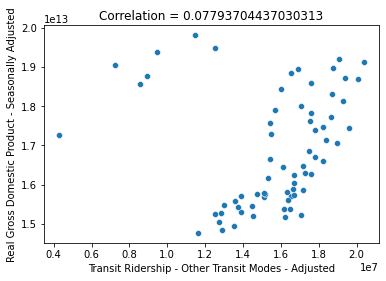

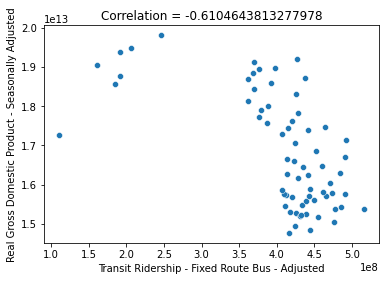

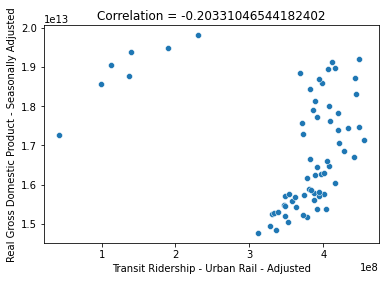

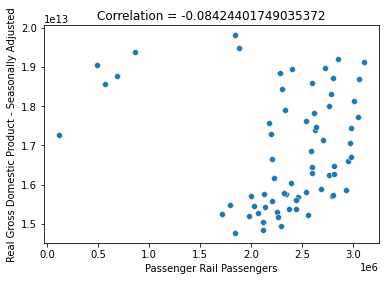

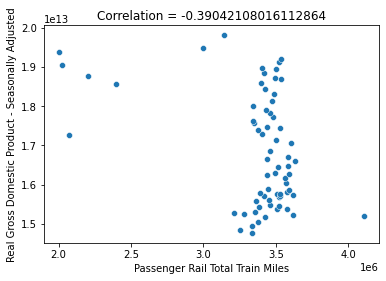

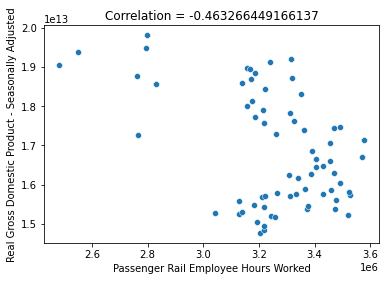

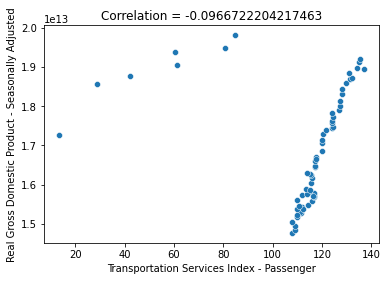

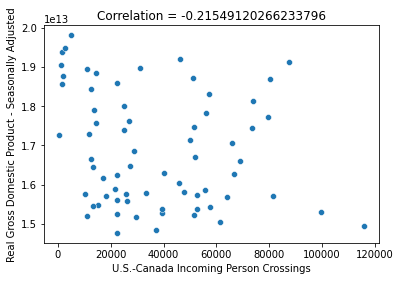

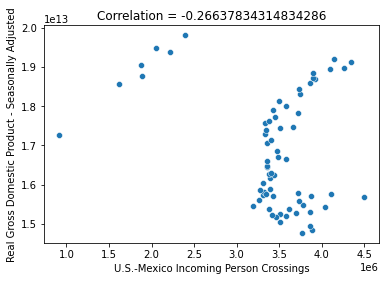

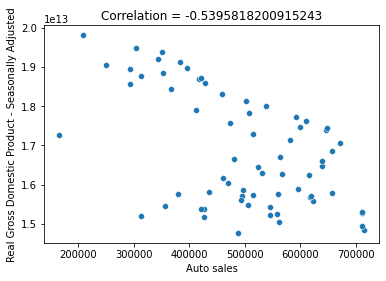

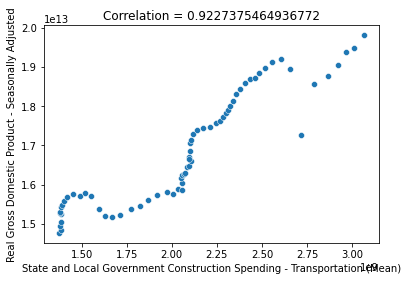

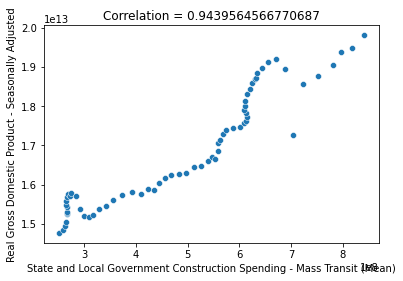

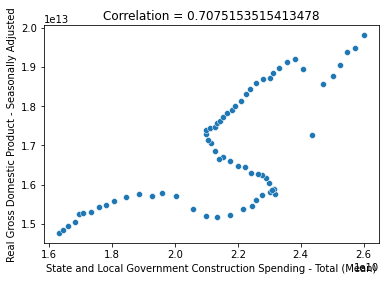

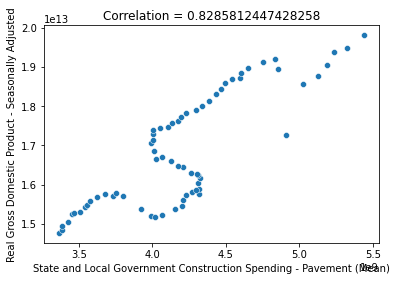

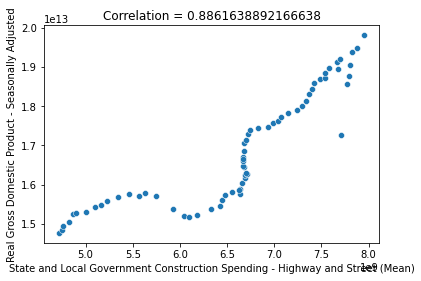

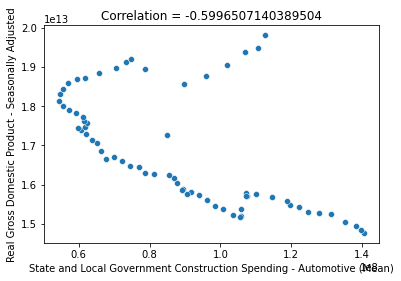

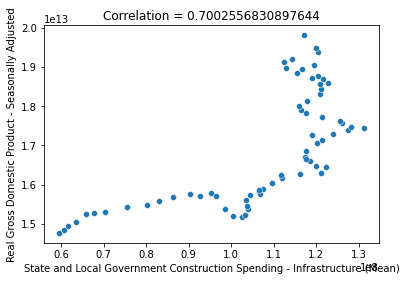

In [73]:
# Plotting and tracking correlation estimates
y_val = "Employment Rate"
correlations = []

for i, feature in enumerate(prediction_columns): 
    plt.figure(i)
    r = correlation_coefficient_estimate(feature, y_val)
    correlations.append((r, feature))
    sns.scatterplot(x=df[feature], y=df[y_val]).set(title="Correlation = " + str(r))

In [74]:
# Sort and output correlations from most correlated to least
correlations.sort(reverse=True, key=lambda x: abs(x[0]))
for r, feature in correlations:
    print(feature + " : " + str(r))

State and Local Government Construction Spending - Mass Transit (Mean) : 0.9439564566770687
State and Local Government Construction Spending - Transportation (Mean) : 0.9227375464936772
State and Local Government Construction Spending - Highway and Street (Mean) : 0.8861638892166638
State and Local Government Construction Spending - Pavement (Mean) : 0.8285812447428258
State and Local Government Construction Spending - Total (Mean) : 0.7075153515413478
State and Local Government Construction Spending - Infrastructure (Mean) : 0.7002556830897644
Transit Ridership - Fixed Route Bus - Adjusted : -0.6104643813277978
State and Local Government Construction Spending - Automotive (Mean) : -0.5996507140389504
Auto sales : -0.5395818200915243
Passenger Rail Employee Hours Worked : -0.463266449166137
Passenger Rail Total Train Miles : -0.39042108016112864
U.S.-Mexico Incoming Person Crossings : -0.26637834314834286
U.S.-Canada Incoming Person Crossings : -0.21549120266233796
Transit Ridership - 

**Describe any trends you observe, and any relationships you may want to follow up on.**

We defined "Employment Rate" as the "Labor Force Participation Rate - Seasonally Adjusted" subtracted by "Unemployment Rate - Seasonally Adjusted".

First, we created scatterplots that plot "Employment Rate" against different features related to transit ridership and spending in the transportation sector. Second, we computed an estimate of the correlation coefficients between these features and "Employment Rate". These features were broken down into their respective categories:

Ridership Category
 - "Highway Vehicle Miles Traveled - All Systems"
 - "Transit Ridership - Other Transit Modes - Adjusted"
 - "Transit Ridership - Fixed Route Bus - Adjusted"
 - "Transit Ridership - Urban Rail - Adjusted
 
Spending Category
 - "State and Local Government Construction Spending - Transportation"
 - "State and Local Government Construction Spending - Mass Transit"
 - "State and Local Government Construction Spending - Total"
 - "National Highway Construction Cost Index (NHCCI)" 
 - "State and Local Government Construction Spending - Pavement" 
 - "State and Local Government Construction Spending - Highway and Street"
 
Based on the scatterplots, we noticed that many variables in the Ridership category have a positive correlation with Employment Rate. We're able to see that the left half of each plots display points that are in a somewhat linear, upward trend. 

On the contrary, we noticed that many variables in the Spending category have a negative correlation with Employment rate. For example, based on our correlation coefficients, we see that increased spending in mass transit systems negatively correlates with Employment rate in the same month ($r = -0.501$).

For variables with low absolute correlation (e.g., National Highway Construction Cost Index (NHCCI)), the points seem to be scattered randomly and show no clear relationships and patterns. It appears that variables related to **public transportation** (e.g., spending on mass transit, ridership on fixed bus routes) have higher absolute correlations compared to other transit modes. The exception to this claim is "Highway Vehicle Miles Traveled - All Systems", which encapsulates both public and private modes of transportation.

Moving forward, we would like to focus on the relationship between the Employment Rate and features related to public transportation. 

**Describe any data cleaning steps you took. How will these decisions impact your models and
inferences?**

For our research question, we narrowed down the dataset to only contain the variables we feel are necessary to answer the question. The main feature we want to predict is: 
 - Employment Rate 
 > This is calculated by taking the difference of "Labor Force Participation Rate - Seasonally Adjusted" and "Unemployment Rate - Seasonally Adjusted" in the given dataset.
  
To help answer the question, we also kept the features we want to use that we think will help to predict the employment rate (and are related to transit ridership and spending in the transportation sector), which are: 
 - "Highway Vehicle Miles Traveled - All Systems"
 - "Transit Ridership - Other Transit Modes - Adjusted"
 - "Transit Ridership - Fixed Route Bus - Adjusted"
 - "Transit Ridership - Urban Rail - Adjusted
 - "State and Local Government Construction Spending - Transportation"
 - "State and Local Government Construction Spending - Mass Transit"
 - "State and Local Government Construction Spending - Total"
 - "National Highway Construction Cost Index (NHCCI)" 
 - "State and Local Government Construction Spending - Pavement" 
 - "State and Local Government Construction Spending - Highway and Street"
 
We decided to keep only the data starting from 01/01/2005 12:00:00 AM since the main features we want to observe (i.e., "Labor Force Participation Rate - Seasonally Adjusted" and "Unemployment Rate - Seasonally Adjusted") only have data starting from that date. 

To compute our correlation coefficient estimates, we examined linear relationships between "Employment Rate" and our selected features. We omitted rows where either "Employment Rate" or the selected feature contained a "NaN" value. This crude approach is formally known as "complete case analysis". This approach contains bias if the Census Bureau chose to omit certain variables non-randomly. Thus, we will primarily use this correlation coefficient as an estimate during EDA, but will look for more advanced approaches such as "multiple imputation" in our final report. 


**Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant.**

Based on our visualizations and estimates for correlation coefficients, we think that public transportation ridership and spending in the public transportation sector may be moderate predictors of employment rate. 

**Ridership**: Assuming that employed workers utilize public transit to some degree, then an increase in public transportation ridership should be positively correlated with an increase in employed workers. Therefore, our EDA suggests a potential answer to our original research question. 

**Spending**: So far, it appears that spending in the transportation sector negatively correlates with employment rate. However, we recognize that the effects of State and Local Government Construction Spending for the given date does not immediately apply to the date. For example, if the government spends a million dollars to revamp BART trains in January 2012, the positive effects of the revamp may take place many months or years later. Thus, for further analysis, we may want to create a variable that tracks spending from $x$ years ago, where $x$ is the average amount of time it takes for revamp efforts in the public transportation sector to positively affect transit systems (or the average amount of time it takes for construction projects in the transportation sector to finish). 

Once we finalize our features, we can build two models. The first, baseline model can use all columns in the Monthly Transportation Dataset to predict Employment Rate. The second, target model can use the features related to public transit ridership and revamp spending to predict Employment Rate. Then, we can compare models and compose an answer to our original research questions. 

### Part 2: Building a Linear GLM to predict GDP

In [75]:
from sklearn.linear_model import LinearRegression 

In [76]:
# Train, test, validation split into 60% train, 20% test, 20% split
train, validate, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [86]:
# Linear regression
X = train[prediction_columns].to_numpy()
Y = train[y_val].to_numpy()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [87]:
rmse_1 = np.sqrt(np.sum(np.power((Y - Y_pred), 2))) 
rmse_1

837304559010.4567

Explanation: TODO 

### Part 3: Building a neural network to predict GDP 

In [90]:
from sklearn.neural_network import MLPRegressor

nn_regressor = MLPRegressor(random_state=1, max_iter=2000).fit(X, Y)
Y_pred = nn_regressor.predict(X)  # make predictions

/Users/micahyong/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [91]:
rmse_2 = np.sqrt(np.sum(np.power((Y - Y_pred), 2))) 
rmse_2

27740207125860.953

In [ ]:
rmse_2 - rmse